In [1]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning)
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, auc
import matplotlib.pyplot as plt

In [2]:
def load_data(filepath):
    data = pd.read_csv(filepath)
    return data

In [3]:
def preprocess_data(data):
    # Drop rows where 'Label' is missing
    if 'Label' in data.columns:
        data.dropna(subset=['Label'], inplace=True)
    else:
        raise KeyError("The 'Label' column is missing from the dataset.")

    # Drop irrelevant columns like 'Attack Type'
    data.drop(columns=['Attack Type'], errors='ignore', inplace=True)

    # Keep only numeric columns
    data = data.select_dtypes(include=[np.number])

    # Label encoding for binary classification
    label_encoder = LabelEncoder()
    data['Label'] = label_encoder.fit_transform(data['Label'])

    # Scaling
    scaler = StandardScaler()
    features = data.drop(columns=['Label'])
    scaled_features = scaler.fit_transform(features)

    return pd.DataFrame(scaled_features, columns=features.columns), data['Label']

In [16]:
class HiddenNaiveBayes:
    def __init__(self):
        self.class_priors = {}
        self.conditional_probs = {}

    def fit(self, X, y):
        num_samples, num_features = X.shape
        classes = np.unique(y)

        # Calculate class priors
        self.class_priors = {c: np.sum(y == c) / num_samples for c in classes}

        # Calculate conditional probabilities
        self.conditional_probs = {}
        for c in classes:
            class_samples = X[y == c].to_numpy()  # Convert to NumPy array
            self.conditional_probs[c] = {}
            for i in range(num_features):
                mean_prob = np.mean(class_samples[:, i])
                self.conditional_probs[c][i] = mean_prob if mean_prob > 0 else 1e-6  # Avoid zero

        return self

    def predict(self, X):
        predictions = []
        X = X.to_numpy()  # Ensure X is a NumPy array
        for x in X:
            posteriors = {}
            for c in self.class_priors:
                # Start with the prior
                posterior = np.log(self.class_priors[c] + 1e-6)  # Add small constant to avoid log(0)
                # Add the conditional probabilities
                for i in range(len(x)):
                    mean_prob = self.conditional_probs[c].get(i, 1e-6)  # Avoid zero or NaN
                    posterior += np.log(mean_prob + 1e-6)
                posteriors[c] = posterior
            # Predict the class with the highest posterior
            predictions.append(max(posteriors, key=posteriors.get))
        return np.array(predictions)

In [29]:
def train_model(X_train, y_train):
    hnb = HiddenNaiveBayes()
    return hnb.fit(X_train, y_train)

def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)

    # Accuracy
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Accuracy: {accuracy}")

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    print("Confusion Matrix:\n", cm)

    # Classification Report
    report = classification_report(y_test, y_pred)
    print("Classification Report:\n", report)

     # Visualize Confusion Matrix
    plt.figure(figsize=(6, 6))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.colorbar()
    tick_marks = np.arange(len(np.unique(y_test)))
    plt.xticks(tick_marks, np.unique(y_test), rotation=45)
    plt.yticks(tick_marks, np.unique(y_test))

    # Annotate Confusion Matrix
    thresh = cm.max() / 2.0
    for i, j in np.ndindex(cm.shape):
        plt.text(j, i, format(cm[i, j], 'd'),
                 horizontalalignment='center',
                 color='white' if cm[i, j] > thresh else 'black')

    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    plt.show()

    # ROC Curve
    fpr, tpr, _ = roc_curve(y_test, y_pred)
    roc_auc = auc(fpr, tpr)
    print(f"ROC AUC Score: {roc_auc}")

    # Visualize ROC Curve
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc='lower right')
    plt.show()



Dataset size after preprocessing: (276, 77), Labels: (276,)
Training set size: (220, 77)
Test set size: (56, 77)
Training labels size: (220,)
Test labels size: (56,)
Accuracy: 0.5178571428571429
Confusion Matrix:
 [[ 0 27]
 [ 0 29]]
Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00        27
           1       0.52      1.00      0.68        29

    accuracy                           0.52        56
   macro avg       0.26      0.50      0.34        56
weighted avg       0.27      0.52      0.35        56



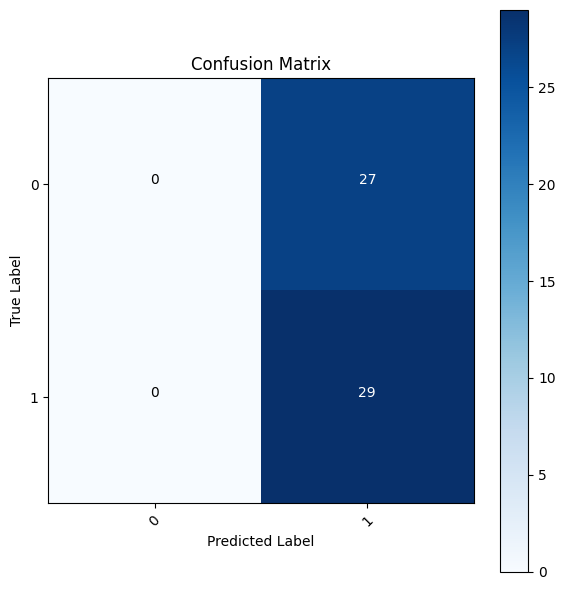

ROC AUC Score: 0.5


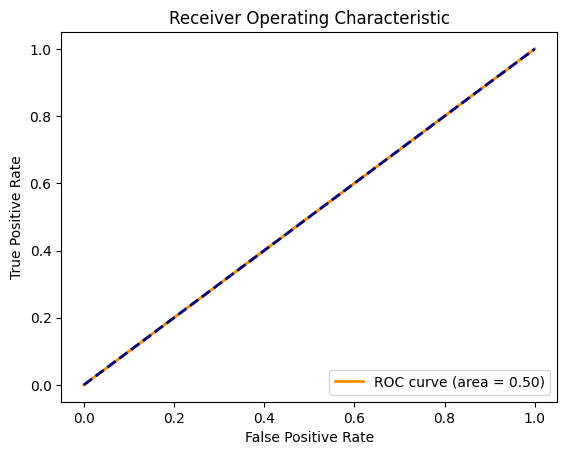

In [30]:
def main():
    filepath = r"C:\\Users\\HP\\Documents\\GitHub\\intrusion-detection-fewshot-vs-traditional\\cleaned_dataset.csv"  
    data = load_data(filepath)

    X, y = preprocess_data(data)
    print(f"Dataset size after preprocessing: {X.shape}, Labels: {y.shape}")

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    print("Training set size:", X_train.shape)
    print("Test set size:", X_test.shape)
    print("Training labels size:", y_train.shape)
    print("Test labels size:", y_test.shape)

    model = train_model(X_train, y_train)
    evaluate_model(model, X_test, y_test)

if __name__ == "__main__":
    main()